# Behavior Preprocessing

## Initialization

## Make tidy group dataframe

In [4]:
%reset -f
from grabbit import Layout
import pandas as pd
import numpy as np
import os
from msit import extract_itis, encode_trial_type_sequence, encode_post_error

layout = Layout('../data', '../data/grabbit_config.json')

# Accumulate individual dataframes to be concatenated at the end
tidy_df = []

# Iterate through the two modalities
# func = fmri
for modality in ['eeg', 'func']:
    
    # Extract out behavior filepaths for all subjects
    behavior_files = layout.get(subject='sub-.*', modality=modality, 
                                extensions='events.tsv')
    
    # Iterate through each subject's behavior file
    for f in behavior_files:
        
        raw_df = pd.read_csv(f.filename, sep='\t', na_values='n/a')
        
        # Encode subject name
        raw_df['participant_id'] = f.subject
        
        # Encode modality
        if modality == 'func':
            raw_df['modality'] = 'fmri'
        else:
            raw_df['modality'] = 'eeg'
            
        # Extract out the itis
        raw_df = extract_itis(raw_df)
        
        # Remove the fixation trials
        trial_ix = raw_df.trial_type != 'fixation'
        raw_df = raw_df[trial_ix].reset_index(drop=True)
        
        # Encode error trials
        raw_df['error'] = 1 - raw_df.response_accuracy
        
        # Encode post error trials
        raw_df = encode_post_error(raw_df)
        
        # Encode no-response trials
        raw_df['no_response'] = 0
        raw_df.loc[raw_df.chosen_response.isnull(), 'no_response'] = 1
        
        # Encode condition sequence effects
        raw_df = encode_trial_type_sequence(raw_df)
        
        # Encode fast response times (< 200 ms)
        raw_df['fast_rt'] = np.where(raw_df.response_time < 0.2, 1, 0)
        
        # Encode trial numbers
        raw_df['trial'] = np.arange(raw_df.shape[0]) + 1
        
        tidy_df.append(raw_df)
        
tidy_df = pd.concat(tidy_df)

# Select out and order columns
tidy_df = tidy_df[['participant_id', 'modality', 'trial', 'onset', 
                   'duration', 'iti', 'trial_type', 'response_time', 
                   'chosen_response', 'correct_response', 
                   'response_accuracy', 'stimulus', 'error', 'post_error', 
                   'no_response', 'trial_type_sequence', 'fast_rt']]
print(tidy_df.head())

# Save out to file
if not os.path.exists('../data/derivatives/behavior'):
    os.makedirs('../data/derivatives/behavior')
tidy_df.to_csv('../data/derivatives/behavior/group_data.tsv', sep='\t',
               index=False, na_rep='n/a')

  participant_id modality  trial    onset  duration   iti   trial_type  \
0      sub-hc001      eeg      1   2.2840      1.75  2.00  incongruent   
1      sub-hc001      eeg      2   6.0330      1.75  1.75    congruent   
2      sub-hc001      eeg      3   9.5346      1.75  2.00  incongruent   
3      sub-hc001      eeg      4  13.2872      1.75  1.75    congruent   
4      sub-hc001      eeg      5  16.7972      1.75  1.75    congruent   

   response_time  chosen_response  correct_response  response_accuracy  \
0        0.87199              2.0                 2                1.0   
1        0.71505              3.0                 3                1.0   
2        1.14070              1.0                 2                0.0   
3        0.59579              2.0                 2                1.0   
4        0.67779              1.0                 1                1.0   

  stimulus  error  post_error  no_response trial_type_sequence  fast_rt  
0      332    0.0           0       

## Validate Task Design

## Group Summary Plots

## Subject Exclusions

# EEG Preprocessing

## Initialization 

EEG isn't standardly supported by the BIDS specification yet. However, we still try to stay reasonably close to the derivatives philosophy currently under development. Thus the preprocessing section (which culminates in cleaned epochs) is stored as an eeg_preprocessing BIDS-derivatives compatible pipeline in the data/derivatives/eeg_preprocessing folder.

In [1]:
%reset -f
from grabbit import Layout
import json
import pickle
import pandas as pd
import numpy as np
from mne.io import Raw
from mne.preprocessing import read_ica
from mne import Epochs, set_log_level, find_events, read_epochs
from autoreject import LocalAutoRejectCV, compute_thresholds
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

from msit import verify_events, epoch_baseline_correct, CH_NAMES
from msit import handle_event_exceptions, visually_verify_epochs
from msit import plot_autoreject_summary, plot_evoked_butterfly
from msit import select_subjects, extract_bad_ch_group_info
from msit import plot_bad_chs_group_summary, extract_bad_epochs_group_info

%matplotlib
set_log_level('critical')

# load eeg configurations
with open('../config.json') as f:    
    config = json.load(f)

# make_eeg_prep_derivatives_folder('../data')
layout = Layout('../data', '../data/grabbit_config.json')
pipeline_root = '../data/derivatives/eeg_preprocessing'

/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Using matplotlib backend: Qt4Agg


## Mark Bad Channels


In [1]:
# extract participant raw filenames
raw_files = layout.get(subject='sub-.*', modality='eeg', 
                       extensions='.fif')

# iterate through participant raw data
for f in raw_files:
    manually_mark_bad_channels(f)

Using matplotlib backend: Qt4Agg


## ICA

### Fit ICA & Auto-Mark EOG & ECG Components

In [ ]:
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
from mne import set_log_level
from mne.io import Raw
from grabbit import Layout
import numpy as np
import matplotlib.pyplot as plt

set_log_level('critical')

pipeline_root = '../data/derivatives/eeg_preprocessing'

# extract participant raw filenames
layout = Layout('../data', './grabbit_config.json')
raw_files = layout.get(subject='sub-.*', modality='eeg', 
                       extensions='_raw.fif')

# iterate through participant 
for f in raw_files:
    
    print(f.subject)
    
    # load in raw with existing bad channels
    raw = Raw(f.filename, verbose=False, preload=True)
    bad_ch_f = layout.get(subject=f.subject, modality='eeg', 
                          derivative='bad_chs')[0].filename
    raw.load_bad_channels(bad_ch_f)
    
    # highpass filter the raw to assist with ICA fitting
    raw.filter(l_freq=1, h_freq=None)
    
    # extract the number of channels to be fit for ICA
    n_components = raw.estimate_rank()
    
    # fit the ica solution
    ica = ICA(n_components=n_components, random_state=50)
    ica.fit(raw, verbose=False)
    
    # save out plots of components
    fig = ica.plot_components(picks=np.arange(n_components), show=False)
    fig.savefig('%s/%s/ica/%s-components.png' % (pipeline_root, f.subject, 
                                                 f.subject))
    
    # iterate through eog and ecg channels
    for ch in ['VEOG', 'HEOG', 'ECG']:
        
        # find the correlation scores between components
        if 'EOG' in ch:
            epochs = create_eog_epochs(raw, ch_name=ch)
            ix, scores = ica.find_bads_eog(epochs, ch_name=ch)
        else:
            epochs = create_ecg_epochs(raw, tmin=-.5, tmax=.5)
            ix, scores = ica.find_bads_ecg(epochs)
            
        # update the ica with the bad components
        ica.labels_[ch] = ix
        ica.exclude += ix
        
        # save correlation scores plot
        fig = ica.plot_scores(scores, exclude=ix, show=False)
        fig.savefig('%s/%s/ica/%s_%s-scores.png' % (pipeline_root,
                                                    f.subject, f.subject,
                                                    ch))
        
    # clean up labels and save ica solution out    
    ica.labels_ = {ch: ica.labels_[ch] for ch in ['VEOG', 'HEOG', 'ECG']}    
    ica.save('%s/%s/ica/%s-ica.fif' % (pipeline_root, f.subject, f.subject))
    plt.close('all')
    
print('Done!')

### Verify ICA Artifact Components

In [ ]:
from mne.preprocessing import read_ica
from mne import set_log_level
from mne.io import Raw
from grabbit import Layout
import numpy as np
import pylab as plt
from eeg_utilities import *

%matplotlib

set_log_level('critical')

pipeline_root = '../data/derivatives/eeg_preprocessing'

# extract participant raw filenames
layout = Layout('../data', './grabbit_config.json')
ica_files = layout.get(subject='sub-pp0[0-4][0-9]', modality='eeg', derivative='ica',
                       extensions='-ica.fif')
raw_files = layout.get(subject='sub-pp0[0-4][0-9]', modality='eeg',
                       extensions='_raw.fif')

# iterate through participants
for raw_f, ica_f in zip(raw_files, ica_files):
    
    print(raw_f.subject)
    ica = read_ica(ica_f.filename)
    raw = Raw(raw_f.filename, preload=True, verbose=False)
    bad_ch_f = layout.get(subject=raw_f.subject, modality='eeg', 
                          derivative='bad_chs')[0].filename
    raw.load_bad_channels(bad_ch_f)
    raw.filter(l_freq=1, h_freq=None)
    
    # repeatedly visualize and adjust excluded components until happy
    ok = 'n'
    while ok != 'y':
    
        # plot summary of corrections epoched to artifact events
        # we use these plots to determine how effective our ica is
        # at correcting the artifacts
        plot_epoched_ica_artifact_info(raw, ica, raw_f.subject, 
                                       pipeline_root)
        
        # plot component time courses for interactive updating of exclusions
        ica.plot_sources(raw, block=True, title=raw_f.subject)
        
        # plot summary of corrections epoched to artifact events
        # we use these plots to determine how effective our ica is
        # at correcting the artifacts
        plot_epoched_ica_artifact_info(raw, ica, raw_f.subject, 
                                       pipeline_root)
        plt.close('all')
        ok = raw_input('OK to move on? (enter y or n):')
        
    ica.save('%s/%s/ica/%s-ica.fif' % (pipeline_root, raw_f.subject, 
                                       raw_f.subject))
print('Done!')

## Generate  & Clean Epochs

### Bandpass Filter & Make Epochs

In [2]:
# extract participant raw, ica, and behavior filenames
layout = Layout('../data', '../data/grabbit_config.json')
ica_files = layout.get(subject='sub-.*', derivative='eeg_preprocessing', 
                       extensions='-ica.fif')
raw_files = layout.get(subject='sub-.*', modality='eeg', 
                       extensions='_raw.fif')
behavior_files = layout.get(subject='sub-.*', modality='eeg',
                            extensions='events.tsv')

# iterate through participants
for raw_f, ica_f, b_f in zip(raw_files, ica_files, behavior_files):
    
    print(raw_f.subject)
        
    # load in data files
    ica = read_ica(ica_f.filename)
    raw = Raw(raw_f.filename, preload=True, verbose=False)
    behavior = pd.read_csv(b_f.filename, sep='\t', na_values='n/a')
    
    # process subject behavior
    behavior = behavior[behavior.trial_type != 'fixation']
    no_response_ix = np.where(behavior.response_time.isnull())[0]
    
    # mark bad channels
    bad_ch_f = layout.get(subject=raw_f.subject, 
                          derivative ='eeg_preprocessing', 
                          extensions='bad_chs.txt')[0].filename
    raw.load_bad_channels(bad_ch_f)
    
    # remove ICA artifacts
    raw = ica.apply(raw, exclude=ica.exclude)
    
    # bandpass filter
    raw.filter(l_freq=config['filter_high_pass'], 
               h_freq=config['filter_low_pass'])
    
    # iterate through epoch types
    for epo_type, event_ch, time_bound in zip(config['epoch_types'],
                                              config['event_channels'],
                                              config['epoch_times']):
    
        # extract events 
        events = find_events(raw, stim_channel=event_ch, output="onset", 
                             verbose=False)

        # verify events
        try:
            verify_events(events, behavior, epo_type)
        except ValueError as err:
            print(err)
            events, no_response_ix = handle_event_exceptions(raw_f.subject, 
                                                              epo_type, 
                                                              events,
                                                              no_response_ix)
        # make epochs
        epochs = Epochs(raw, events, 
                        tmin=time_bound[0] - config['filter_buffer'], 
                        tmax=time_bound[1] + config['filter_buffer'], 
                        baseline=None, proj=False, detrend=1,
                        preload=True, verbose=False, 
                        reject_by_annotation=False)
        
        # remove non-responses
        if epo_type != 'response':
            epochs.drop(no_response_ix)
        
        # baseline correct
        # assumes that the epochs type containing the baseline is the 
        # first in the list
        if epo_type == config['baseline_container']:
            baseline = epochs.copy().crop(config['baseline_period'][0],
                                          config['baseline_period'][1])
        epochs = epoch_baseline_correct(epochs, baseline.get_data())
        print(epochs)
        
        # save to file
        f = '%s/%s/epochs/%s_%s_uncleaned-epo.fif'
        epochs.save(f % (pipeline_root, raw_f.subject, raw_f.subject, 
                         epo_type))
print('Done!')    

sub-hc001
<Epochs  |  n_events : 181 (all good), tmin : -1.0 (s), tmax : 2.25 (s), baseline : None, ~382.2 MB, data loaded>
<Epochs  |  n_events : 181 (all good), tmin : -1.5 (s), tmax : 1.5 (s), baseline : None, ~353.2 MB, data loaded>
sub-hc002
<Epochs  |  n_events : 190 (all good), tmin : -1.0 (s), tmax : 2.25 (s), baseline : None, ~401.0 MB, data loaded>
<Epochs  |  n_events : 190 (all good), tmin : -1.5 (s), tmax : 1.5 (s), baseline : None, ~370.5 MB, data loaded>
sub-hc003
<Epochs  |  n_events : 191 (all good), tmin : -1.0 (s), tmax : 2.25 (s), baseline : None, ~403.1 MB, data loaded>
<Epochs  |  n_events : 191 (all good), tmin : -1.5 (s), tmax : 1.5 (s), baseline : None, ~372.5 MB, data loaded>
sub-hc004
<Epochs  |  n_events : 192 (all good), tmin : -1.0 (s), tmax : 2.25 (s), baseline : None, ~405.2 MB, data loaded>
<Epochs  |  n_events : 192 (all good), tmin : -1.5 (s), tmax : 1.5 (s), baseline : None, ~374.4 MB, data loaded>
sub-hc005
<Epochs  |  n_events : 192 (all good), tmi

sub-hc036
<Epochs  |  n_events : 191 (all good), tmin : -1.0 (s), tmax : 2.25 (s), baseline : None, ~403.1 MB, data loaded>
<Epochs  |  n_events : 191 (all good), tmin : -1.5 (s), tmax : 1.5 (s), baseline : None, ~372.5 MB, data loaded>
sub-hc037
<Epochs  |  n_events : 191 (all good), tmin : -1.0 (s), tmax : 2.25 (s), baseline : None, ~403.1 MB, data loaded>
<Epochs  |  n_events : 191 (all good), tmin : -1.5 (s), tmax : 1.5 (s), baseline : None, ~372.5 MB, data loaded>
sub-hc042
<Epochs  |  n_events : 186 (all good), tmin : -1.0 (s), tmax : 2.25 (s), baseline : None, ~392.7 MB, data loaded>
<Epochs  |  n_events : 186 (all good), tmin : -1.5 (s), tmax : 1.5 (s), baseline : None, ~362.9 MB, data loaded>
sub-hc044
<Epochs  |  n_events : 160 (all good), tmin : -1.0 (s), tmax : 2.25 (s), baseline : None, ~338.5 MB, data loaded>
<Epochs  |  n_events : 160 (all good), tmin : -1.5 (s), tmax : 1.5 (s), baseline : None, ~312.9 MB, data loaded>
sub-hc045
<Epochs  |  n_events : 166 (all good), tmi

### Autoreject

In [1]:
subjects = np.array(sorted(layout.get(target='subject', 
                                      modality='eeg',
                                      return_type='id')))
start_ix = np.where(subjects == 'sub-hc033')[0][0]
end_ix = np.where(subjects == 'sub-pp001')[0]
subjects = subjects[start_ix:]

# parallelize and seed autoreject threshold function
thresh_func = partial(compute_thresholds, random_state=42, n_jobs=5)

# iterate through epoch types
for sub in subjects:
    
    print(sub)
    epochs = []
    ar_epochs = []
    
    for epo_type, time_bound in zip(config['epoch_types'],
                                    config['epoch_times']):
        print(epo_type)
    
        # load uncleaned epochs
        epoch_file = layout.get(subject=sub, 
                                derivative='eeg_preprocessing', 
                                extensions='%s_uncleaned-epo.fif' % epo_type)
        epoch = read_epochs(epoch_file[0].filename, verbose=False)
        
        # fit autoreject
        ar = LocalAutoRejectCV(consensus_percs=config['consensus_percs'],
                               n_interpolates=config['n_interpolates'],
                               thresh_func=thresh_func, verbose=False)
        ar.fit(epoch)
        
        # save autoreject to file
        pickle_file = '%s/%s/autoreject/%s_%s_ar.pkl' % (pipeline_root,
                                                         sub, sub,
                                                         epo_type)
        with open(pickle_file, 'w') as output:
            pickle.dump(ar, output, pickle.HIGHEST_PROTOCOL)
            
        # create and save autoreject diagnostic plot
        plot_autoreject_summary(ar, sub, epo_type, pipeline_root,
                                epoch.ch_names)
        plt.close('all')
        
        epochs.append(epoch)
        ar_epochs.append(ar.transform(epoch))
        
    # plot evoked data before and after autoreject
    for period, epos in zip(['before', 'after'], [epochs, ar_epochs]):
        fig = plot_evoked_butterfly(epos, config)
        fig.suptitle('%s %s Autoreject' % (sub, period.capitalize()))
        f = ('%s/%s/autoreject/%s_%s_autoreject_butterfly.png')
        fig.savefig(f % (pipeline_root, sub, sub, period))
        plt.close(fig)
    plt.close('all')
        
print('Done!')

/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Using matplotlib backend: Qt4Agg
sub-hc033
stimulus
response
0


/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


1
0
1
sub-hc034
stimulus
response
0
1
0
1
sub-hc035
stimulus
response
0
1
0
1
sub-hc036
stimulus
response


/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/site-packages/autoreject-0.1.dev0-py2.7.egg/autoreject/autoreject.py:640: UserWarning: No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


0
1
0
1
sub-hc037
stimulus
response
0
1
0
1
sub-hc042
stimulus
response
0
1
0
1
sub-hc044
stimulus
response
0
1
0
1
sub-hc045
stimulus
response
0
1
0
1
sub-pp001
stimulus
response
0
1
0
1
sub-pp002
stimulus
response
0
1
0
1
sub-pp003
stimulus
response
0
1
0
1
sub-pp004
stimulus
response
0
1
0
1
sub-pp005
stimulus
response
0
1
0
1
sub-pp006
stimulus
response
0
1
0
1
sub-pp007
stimulus
response
0
1
0
1
sub-pp008
stimulus
response
0
1
0
1
sub-pp009
stimulus
response
0
1
0
1
sub-pp010
stimulus
response
0
1
0
1
sub-pp011
stimulus
response
0
1
0
1
sub-pp012
stimulus
response
0
1
0
1
sub-pp013
stimulus
response
0
1
0
1
sub-pp014
stimulus
response
0
1
0
1
sub-pp015
stimulus
response
0
1
0
1
sub-pp016
stimulus
response
0
1
0
1
Done!


### Update Bad Channels & Average Re-Reference

Notes:
- hc004: occipitals have a weird linear increasing baseline (even though linear detrended?)
- hc008: funky oscillations - alpha? Just generally really noisy.
- hc018: exclude- more than half of channels bad.
- hc029: noisy with lots of bad channels
- hc045: frontals not flat in baseline, maybe missing ica components?
- pp001: just looks like noise
- pp004: looks really bad, didn't even try to throw out channels
- pp013: weird positive frontal and negative occipital linear trends



In [ ]:
subjects = np.array(sorted(layout.get(target='subject', 
                                      modality='eeg',
                                      return_type='id')))
start_ix = np.where(subjects == 'sub-hc022')[0][0]
end_ix = np.where(subjects == 'sub-hc024')[0][0]
subjects = subjects[start_ix:end_ix + 1]
    
# iterate through participants
for sub in subjects:
    
    print(sub)
    
    # load and autoreject transform epochs
    epoch_files = layout.get(subject=sub,
                         derivative='eeg_preprocessing',
                         extensions='uncleaned-epo.fif')
    ar_files = layout.get(subject=sub,
                          derivative='eeg_preprocessing',
                          extensions='ar.pkl')
    epochs = [read_epochs(f.filename, verbose=False) 
              for f in epoch_files][::-1]
    ars = [pickle.load(open(f.filename, 'r')) for f in ar_files][::-1]
    epochs = [ar.transform(epoch) for ar, epoch in zip(ars, epochs)]
        
    # visually verify and update bad channels on epochs
    bad_chs = visually_verify_epochs(sub, epochs, config)
    
    # update bads and average re-reference
    for epoch in epochs:
        epoch.info['bads'] = bad_chs
        epoch.set_eeg_reference().apply_proj()
        
    # save cleaned epochs to file
    for i, epo_type in enumerate(config['epoch_types']):
        f = '%s/%s/epochs/%s_%s_cleaned-epo.fif'
        epochs[i].save(f % (pipeline_root, sub, sub, epo_type))
        
    # save cleaned epochs butterfly plot
    [epochs[i].crop(config['epoch_times'][i][0], 
                config['epoch_times'][i][1]) for i in range(len(epochs))]
    fig = plot_evoked_butterfly(epochs, config)
    fig.suptitle('%s Cleaned' % sub)
    f = '%s/%s/%s_cleaned_butterfly.png'
    fig.savefig(f % (pipeline_root, sub, sub))
        
    # save channel sensors plot
    fig = epochs[0].plot_sensors(show=True, title=sub, show_names=True)
    fig.savefig('%s/%s/%s_sensors.png' % (pipeline_root, sub, sub))
    plt.close('all')
        
print('Done!')

Using matplotlib backend: Qt4Agg
sub-hc022


/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


## Group Summary Plots

### Bad Channels

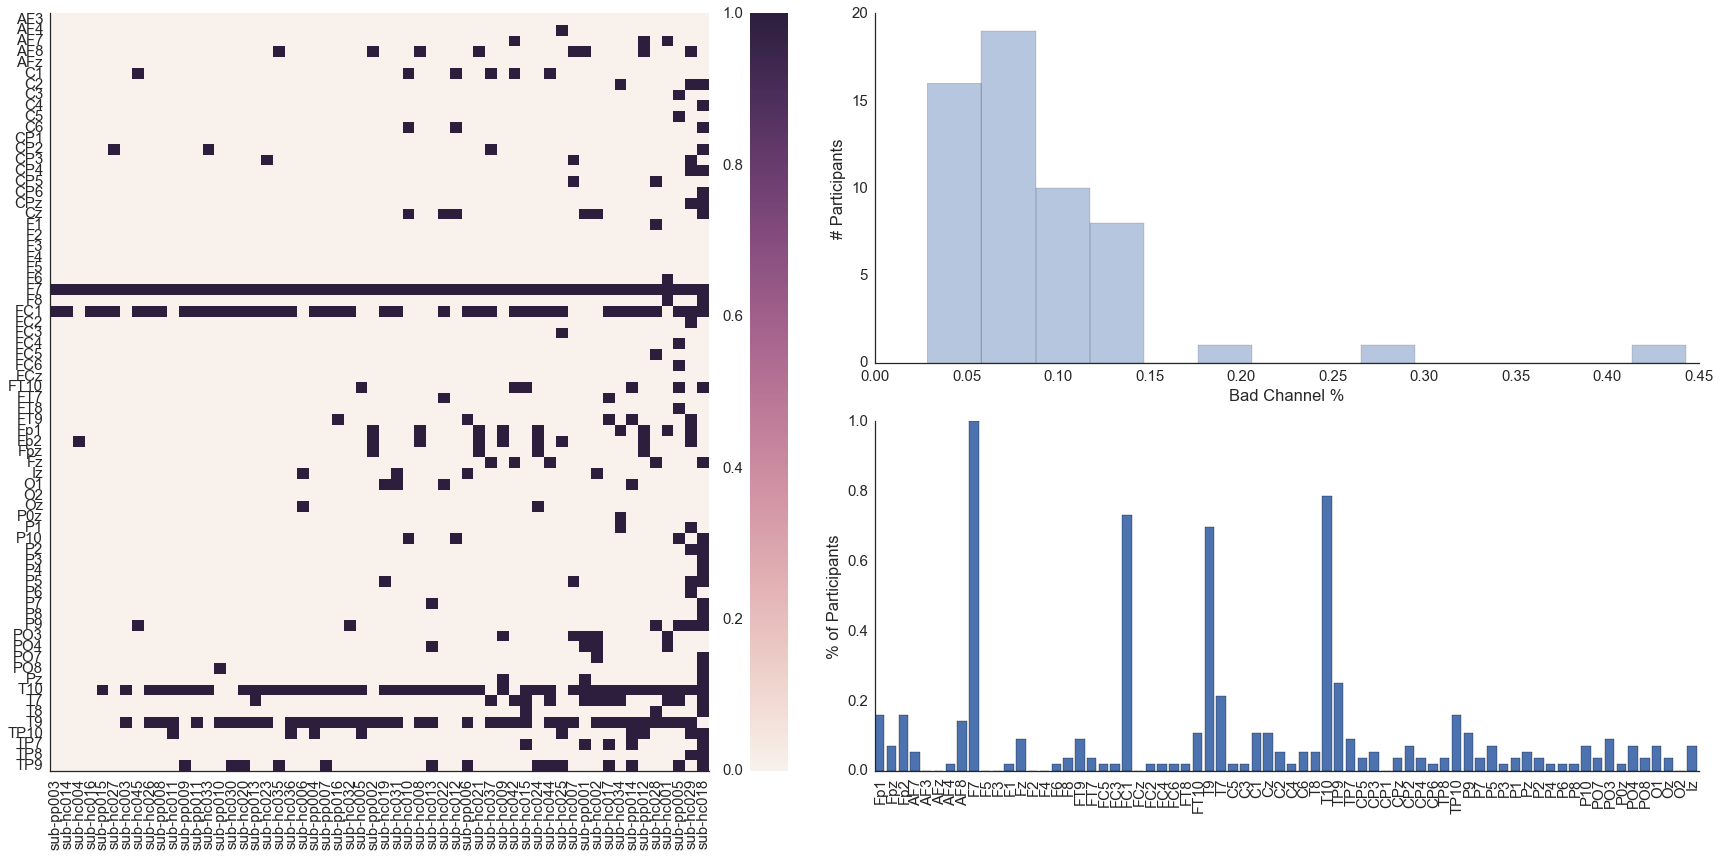

In [10]:
%matplotlib inline
bad_ch_info = extract_bad_ch_group_info('../data/derivatives/eeg_preprocessing', CH_NAMES)
fig = plot_bad_chs_group_summary(bad_ch_info)
plt.show(fig)

### Bad Epochs

In [2]:
bad_epoch_info = extract_bad_epochs_group_info('../data/derivatives/eeg_preprocessing', CH_NAMES)

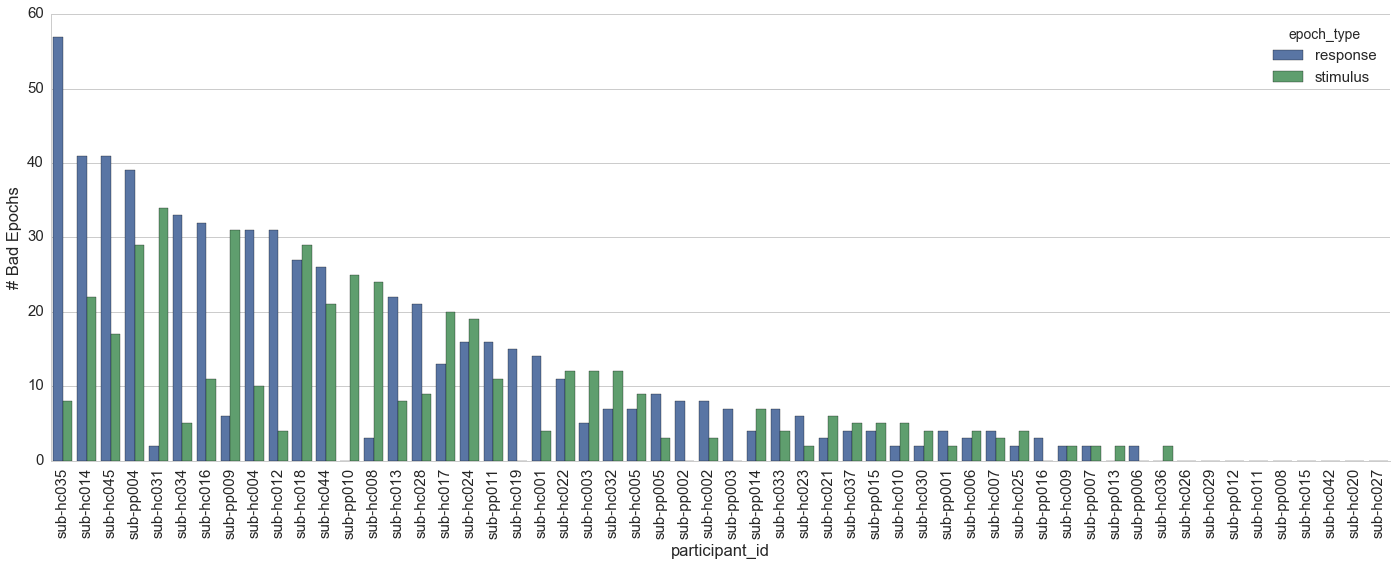

In [3]:
%matplotlib inline
plt.figure(figsize=(24, 8))
sns.barplot(x='participant_id', y='num_bad', hue='epoch_type', 
            data=bad_epoch_info.sort_values(by='num_bad', ascending=False))
plt.xticks(rotation=90)
plt.ylabel('# Bad Epochs')
sns.despine()
plt.show()

## Subject Exclusions

# fMRI Preprocessing